# Natutal Language Processing (NLP) - Sentiment Analysis

## The North Face

VADER (Valence Aware Dictionary and Sentiment Reasoner) - Bag of words approach

Roberta Pretrained Model from 🤗

Huggingface Pipeline

## (II) RoBERTa Model

- Use a model trained of a large corpus of data
- Transfomer model accounts for the words but also the context related to other words

In [2]:
pip install transformers


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install torchtext

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install --upgrade torchtext

  Using cached torchtext-0.15.2-cp39-cp39-win_amd64.whl (1.9 MB)
  Using cached torch-2.0.1-cp39-cp39-win_amd64.whl (172.4 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0
    Uninstalling torch-1.9.0:
      Successfully uninstalled torch-1.9.0
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.10.0
    Uninstalling torchtext-0.10.0:
      Successfully uninstalled torchtext-0.10.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchtext==0.9.0

Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install torchtext==0.10.0

In [12]:
pip install torchtext==0.10.0 --user

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip show torchtext

Name: torchtext
Version: 0.9.0
Summary: Text utilities and datasets for PyTorch
Home-page: https://github.com/pytorch/text
Author: PyTorch core devs and James Bradbury
Author-email: jekbradbury@gmail.com
License: BSD
Location: c:\users\peini\anaconda3\lib\site-packages
Requires: numpy, requests, torch, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

In [1]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import pandas as pd
import numpy as np

In [3]:
from transformers import RobertaTokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [4]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

### Data Pre-Processing

In [5]:
# Read in data
df = pd.read_excel('excel_file.xlsx')
print(df.shape)

(3848, 7)


In [6]:
df.head(10)

,name,price,reviewers,dates,ratings,titles,contents
0,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Abraham,"Reviewed in the United States on June 4, 2023",4.6 out of 5,Worth every penny,This is a must have if you are in a rainy area...
1,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,The Review,"Reviewed in the United States on April 23, 2023",4.6 out of 5,comfortable and completely water proof,"very wet rainy season this year, so had ample ..."
2,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Abraham,"Reviewed in the United States on June 4, 2023",4.6 out of 5,Muy útil,"Cómoda , resiste el frío y el agua"
3,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Amazon Customer,"Reviewed in the United States on May 17, 2023",4.6 out of 5,Very Nice,Fits well and great materials and construction
4,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Nelson Junior Jara Montiel,"Reviewed in the United States on May 28, 2023",4.6 out of 5,"Different fit, cheaper design",I am replacing the original venture jacket. Th...
5,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,JRandyMyrick,"Reviewed in the United States on May 1, 2023",4.6 out of 5,Garment,Color inside. Pockets
6,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,The Review,"Reviewed in the United States on April 23, 2023",4.6 out of 5,Keeps me dry.,The jacket looks to be well made and did a gre...
7,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,harv,"Reviewed in the United States on June 3, 2023",4.6 out of 5,Outstanding Quality,Exactly what I ordered! The product is outstan...
8,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Sam,"Reviewed in the United States on February 27, ...",4.6 out of 5,as expected,very lightweight weatherproof shell. the mater...
9,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Amy,"Reviewed in the United States on March 18, 2023",4.6 out of 5,It's just a basic windbreaker,You're definitly only paying for the name. The...


### Data Cleaning

In [7]:
import pandas as pd
import numpy as np

def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=True)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

def check_dataframe(df, head=5, tail=5):
    print('SHAPE'.center(82, '~'))
    print('Rows: {}'.format(df.shape[0]))
    print('Columns: {}'.format(df.shape[1]))
    print('TYPES'.center(82, '~'))
    print(df.dtypes)
    print("~" * 82)
    print(missing_values_analysis(df))
    print('DUPLICATED VALUES'.center(83, '~'))
    print(df.duplicated().sum())
    print("QUANTILES".center(82, '~'))
    print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_dataframe(df)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 3848
Columns: 7
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
name         object
price        object
reviewers    object
dates        object
ratings      object
titles       object
contents     object
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
           Missing Values  Ratio
ratings                39   1.01
dates                  57   1.48
titles                 62   1.61
name                   75   1.95
contents               80   2.08
reviewers             207   5.38
price                1448  37.63
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~DUPLICATED VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
90
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~QUANTILES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Empty DataFrame
Columns: [0.0, 0.05, 0.5, 0.95, 0.99, 1.0]
Index: []


C:\Users\peini\AppData\Local\Temp\ipykernel_39352\2773696479.py:23: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [8]:
# Replace missing values with "anonymous" in the entire dataframe
df_filled = df.fillna("anonymous")

# Replace missing values with "anonymous" in a specific column
df['reviewers'] = df['reviewers'].fillna("anonymous")

In [9]:
def remove_repeated_words(dates):
    if isinstance(dates, float):
        return dates
    words = str(dates).split()
    unique_words = []
    for word in words:
        if word != 'Reviewed' and word != 'in' and word != 'the' and word != 'United' and word != 'States' and word != 'on' and word != 'Germany' and word != 'Canada' and word != 'France' and word != 'Italy' and  word != 'Australia' and word != 'Kingdom' and word != 'Japan' and word != 'Singapore' and word != 'Spain' and word != 'Mexico' and word != 'India' and word != 'Brazil' :
            unique_words.append(word)
    return ' '.join(unique_words)

In [10]:
df['dates'] = df['dates'].apply(remove_repeated_words)
df['dates']

0         June 4, 2023
1       April 23, 2023
2         June 4, 2023
3         May 17, 2023
4         May 28, 2023
             ...      
3843               NaN
3844               NaN
3845               NaN
3846      May 25, 2023
3847      May 25, 2023
Name: dates, Length: 3848, dtype: object

In [11]:
# Convert 'Date' column to datetime type
df['dates'] = pd.to_datetime(df['dates'])

# Fill missing values with a specific date
df['dates'] = df['dates'].fillna(method='ffill')

In [12]:
def remove_repeated_words(ratings):
    if isinstance(ratings, float):
        return ratings
    words = str(ratings).split()
    unique_words = []
    for word in words:
        if word != 'out' and word != 'of' and word != '5' :
            unique_words.append(word)
    return ' '.join(unique_words)

In [13]:
df['ratings'] = df['ratings'].apply(remove_repeated_words)
df['ratings']

0       4.6
1       4.6
2       4.6
3       4.6
4       4.6
       ... 
3843    5.0
3844    5.0
3845    NaN
3846    5.0
3847    5.0
Name: ratings, Length: 3848, dtype: object

In [14]:
df['ratings'].unique()

array(['4.6', '4.3', nan, '4.4', '4.7', '4', '4.5', '', '4.2', '4.8',
       '3.0', '5.0', '4.1'], dtype=object)

In [15]:
# Clean the 'ratings' column
df['ratings'] = pd.to_numeric(df['ratings'], errors='coerce')
# Convert the 'ratings' column to float
df['ratings'] = df['ratings'].astype(float)

In [16]:
# Calculate the mean rating
mean_rating = df['ratings'].mean()

# Fill missing values with the mean rating
df['ratings'] = df['ratings'].fillna(mean_rating)

In [17]:
df['ratings'].unique()

array([4.6       , 4.3       , 4.58677555, 4.4       , 4.7       ,
       4.        , 4.5       , 4.2       , 4.8       , 3.        ,
       5.        , 4.1       ])

In [18]:
df['price']

0       $109.85 -\n$109.95
1       $109.85 -\n$109.95
2       $109.85 -\n$109.95
3       $109.85 -\n$109.95
4       $109.85 -\n$109.95
               ...        
3843                $29.95
3844                $29.95
3845                $34.95
3846                $34.95
3847                $34.95
Name: price, Length: 3848, dtype: object

In [19]:
df_filled = df.fillna("price")

df['price'] = df['price'].fillna(method='bfill')

In [20]:
df_filled = df.fillna("name")

df['name'] = df['name'].fillna(method='ffill')

In [21]:
df = df.dropna()

In [22]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=True)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

def check_dataframe(df, head=5, tail=5):
    print('SHAPE'.center(82, '~'))
    print('Rows: {}'.format(df.shape[0]))
    print('Columns: {}'.format(df.shape[1]))
    print('TYPES'.center(82, '~'))
    print(df.dtypes)
    print("~" * 82)
    print(missing_values_analysis(df))
    print('DUPLICATED VALUES'.center(83, '~'))
    print(df.duplicated().sum())
    print("QUANTILES".center(82, '~'))
    print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_dataframe(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 3765
Columns: 7
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
name                 object
price                object
reviewers            object
dates        datetime64[ns]
ratings             float64
titles               object
contents             object
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Empty DataFrame
Columns: [Missing Values, Ratio]
Index: []
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~DUPLICATED VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
80
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~QUANTILES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
         0.00  0.05  0.50  0.95  0.99  1.00
ratings   4.0   4.3   4.6   4.7   4.7   5.0


C:\Users\peini\AppData\Local\Temp\ipykernel_39352\3513344389.py:20: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [23]:
df_no_duplicates = df.drop_duplicates()

In [24]:
df.drop_duplicates(inplace=True)

In [25]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=True)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

def check_dataframe(df, head=5, tail=5):
    print('SHAPE'.center(82, '~'))
    print('Rows: {}'.format(df.shape[0]))
    print('Columns: {}'.format(df.shape[1]))
    print('TYPES'.center(82, '~'))
    print(df.dtypes)
    print("~" * 82)
    print(missing_values_analysis(df))
    print('DUPLICATED VALUES'.center(83, '~'))
    print(df.duplicated().sum())
    print("QUANTILES".center(82, '~'))
    print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_dataframe(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 3685
Columns: 7
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
name                 object
price                object
reviewers            object
dates        datetime64[ns]
ratings             float64
titles               object
contents             object
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Empty DataFrame
Columns: [Missing Values, Ratio]
Index: []
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~DUPLICATED VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~QUANTILES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
         0.00  0.05  0.50  0.95  0.99  1.00
ratings   4.0   4.4   4.6   4.7   4.7   5.0


C:\Users\peini\AppData\Local\Temp\ipykernel_39352\3513344389.py:20: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [26]:
df.head(10)

,name,price,reviewers,dates,ratings,titles,contents
0,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Abraham,2023-06-04,4.6,Worth every penny,This is a must have if you are in a rainy area...
1,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,The Review,2023-04-23,4.6,comfortable and completely water proof,"very wet rainy season this year, so had ample ..."
2,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Abraham,2023-06-04,4.6,Muy útil,"Cómoda , resiste el frío y el agua"
3,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Amazon Customer,2023-05-17,4.6,Very Nice,Fits well and great materials and construction
4,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Nelson Junior Jara Montiel,2023-05-28,4.6,"Different fit, cheaper design",I am replacing the original venture jacket. Th...
5,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,JRandyMyrick,2023-05-01,4.6,Garment,Color inside. Pockets
6,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,The Review,2023-04-23,4.6,Keeps me dry.,The jacket looks to be well made and did a gre...
7,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,harv,2023-06-03,4.6,Outstanding Quality,Exactly what I ordered! The product is outstan...
8,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Sam,2023-02-27,4.6,as expected,very lightweight weatherproof shell. the mater...
9,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Amy,2023-03-18,4.6,It's just a basic windbreaker,You're definitly only paying for the name. The...


In [27]:
df = df.reset_index()

In [28]:
df.head(10)

,index,name,price,reviewers,dates,ratings,titles,contents
0,0,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Abraham,2023-06-04,4.6,Worth every penny,This is a must have if you are in a rainy area...
1,1,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,The Review,2023-04-23,4.6,comfortable and completely water proof,"very wet rainy season this year, so had ample ..."
2,2,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Abraham,2023-06-04,4.6,Muy útil,"Cómoda , resiste el frío y el agua"
3,3,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Amazon Customer,2023-05-17,4.6,Very Nice,Fits well and great materials and construction
4,4,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Nelson Junior Jara Montiel,2023-05-28,4.6,"Different fit, cheaper design",I am replacing the original venture jacket. Th...
5,5,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,JRandyMyrick,2023-05-01,4.6,Garment,Color inside. Pockets
6,6,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,The Review,2023-04-23,4.6,Keeps me dry.,The jacket looks to be well made and did a gre...
7,7,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,harv,2023-06-03,4.6,Outstanding Quality,Exactly what I ordered! The product is outstan...
8,8,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Sam,2023-02-27,4.6,as expected,very lightweight weatherproof shell. the mater...
9,9,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Amy,2023-03-18,4.6,It's just a basic windbreaker,You're definitly only paying for the name. The...


In [29]:
df['ratings'].unique()

array([4.6       , 4.3       , 4.4       , 4.7       , 4.        ,
       4.5       , 4.58677555, 4.8       , 4.1       , 4.2       ,
       5.        ])

In [30]:
# df = pd.read_excel('excel_file.xlsx')

# Convert 'ratings' column to numeric
# df['ratings'] = pd.to_numeric(df['ratings'], errors='coerce')

# Create a new column 'converted_ratings' based on the comparison
# df['converted_ratings'] = df['ratings'].apply(lambda x: 1 if x > 4.5 else 0)
df['converted_ratings'] = df['ratings'].apply(lambda x: 1 if float(x) >= 4.5 else 0 if float(x) < 4.5 else None)


# Concatenate 'titles' and 'contents' columns into a new column
df['titles_contents'] = df['titles'] + ". " + df['contents']


In [31]:
df['converted_ratings']

0       1
1       1
2       1
3       1
4       1
       ..
3680    0
3681    0
3682    0
3683    0
3684    1
Name: converted_ratings, Length: 3685, dtype: int64

In [32]:
df['ratings']

0       4.6
1       4.6
2       4.6
3       4.6
4       4.6
       ... 
3680    4.4
3681    4.4
3682    4.4
3683    4.4
3684    5.0
Name: ratings, Length: 3685, dtype: float64

In [33]:
df['ratings'].unique()

array([4.6       , 4.3       , 4.4       , 4.7       , 4.        ,
       4.5       , 4.58677555, 4.8       , 4.1       , 4.2       ,
       5.        ])

In [34]:
df['titles_contents'] 

0       Worth every penny. This is a must have if you ...
1       comfortable and completely water proof. very w...
2            Muy útil. Cómoda , resiste el frío y el agua
3       Very Nice. Fits well and great materials and c...
4       Different fit, cheaper design. I am replacing ...
                              ...                        
3680    Finally a hat that looks decent on me. so smal...
3681    The North Face Logo is easily removed!!. Perfe...
3682    this hat was way too small. I love this hat! I...
3683    Finally a hat that looks decent on me. Great H...
3684    Loved it. Bucket hat with SPF and a pocket! Th...
Name: titles_contents, Length: 3685, dtype: object

C:\Users\peini\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'length')

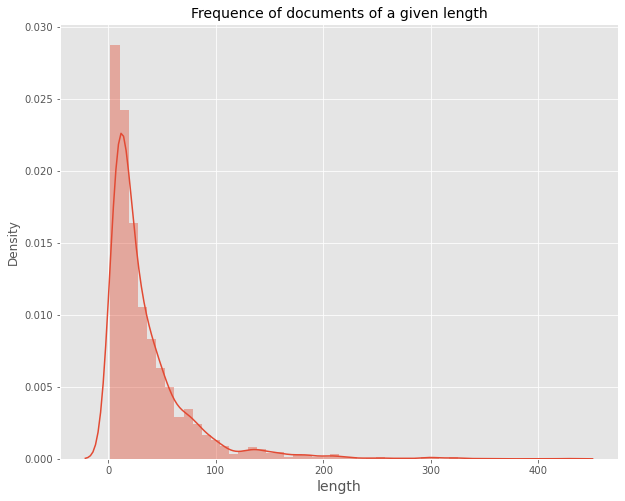

In [35]:
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
# df['length'] = df['titlescontents'].apply(lambda x: len(x.split()))
df['length'] = df['titles_contents'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
sns.distplot(df[df['length'] < 5000]['length'])
plt.title('Frequence of documents of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)

In [36]:
df['titles_contents'] = df['titles_contents'].apply(lambda x: " ".join(x.split()[:512]) if isinstance(x, str) else "")
df['titles_contents'] = df['titles_contents'].astype(str).apply(lambda x: " ".join(x.split()[:512]) if isinstance(x, str) else "")
# df.to_excel('<output_path>/prep_excel_file.xlsx')
df.to_excel('prep_excel_file_final.xlsx')

- The histogram depicts the text length distribusion 

In [37]:
empty_values_count = df.isnull().sum()
print(empty_values_count)

index                0
name                 0
price                0
reviewers            0
dates                0
ratings              0
titles               0
contents             0
converted_ratings    0
titles_contents      0
length               0
dtype: int64


### Model Training and Fine-Tuning

In [38]:
# Import the lexicon
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
# Create an instance of SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [39]:
example = df['contents'][100]
print(example)

The picture and color are too different. The photo is shown like khaki, but it is actually navy color.


In [40]:
# VADER results on example
print(example)
sia.polarity_scores(example)

The picture and color are too different. The photo is shown like khaki, but it is actually navy color.


{'neg': 0.0, 'neu': 0.911, 'pos': 0.089, 'compound': 0.1901}

In [41]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.31779596, 'roberta_neu': 0.6235217, 'roberta_pos': 0.05868239}


In [42]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [43]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        contents = row['contents']
        index = row['index']
        vader_result = sia.polarity_scores(contents)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(contents)
        both = {**vader_result_rename, **roberta_result}
        res[index] = both
    except RuntimeError:
        print(f'Broke for id {index}')

  0%|          | 0/3685 [00:00<?, ?it/s]

Broke for id 3394


In [44]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'index'})
results_df = results_df.merge(df, how='left')

In [45]:
results_df.head(10)

,index,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,name,price,reviewers,dates,ratings,titles,contents,converted_ratings,titles_contents,length
0,0,0.029,0.737,0.234,0.8473,0.002333,0.034382,0.963286,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Abraham,2023-06-04,4.6,Worth every penny,This is a must have if you are in a rainy area...,1,Worth every penny. This is a must have if you ...,48
1,1,0.051,0.677,0.272,0.7810,0.002992,0.048708,0.948300,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,The Review,2023-04-23,4.6,comfortable and completely water proof,"very wet rainy season this year, so had ample ...",1,comfortable and completely water proof. very w...,30
2,2,0.000,1.000,0.000,0.0000,0.097650,0.820784,0.081566,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Abraham,2023-06-04,4.6,Muy útil,"Cómoda , resiste el frío y el agua",1,"Muy útil. Cómoda , resiste el frío y el agua",10
3,3,0.000,0.446,0.554,0.7351,0.003950,0.071658,0.924392,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Amazon Customer,2023-05-17,4.6,Very Nice,Fits well and great materials and construction,1,Very Nice. Fits well and great materials and c...,9
4,4,0.060,0.843,0.096,0.3716,0.564688,0.366071,0.069241,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Nelson Junior Jara Montiel,2023-05-28,4.6,"Different fit, cheaper design",I am replacing the original venture jacket. Th...,1,"Different fit, cheaper design. I am replacing ...",155
5,5,0.000,1.000,0.000,0.0000,0.224240,0.711936,0.063824,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,JRandyMyrick,2023-05-01,4.6,Garment,Color inside. Pockets,1,Garment. Color inside. Pockets,4
6,6,0.000,0.771,0.229,0.8910,0.003664,0.034134,0.962202,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,The Review,2023-04-23,4.6,Keeps me dry.,The jacket looks to be well made and did a gre...,1,Keeps me dry.. The jacket looks to be well mad...,49
7,7,0.000,0.752,0.248,0.6476,0.003090,0.022709,0.974201,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,harv,2023-06-03,4.6,Outstanding Quality,Exactly what I ordered! The product is outstan...,1,Outstanding Quality. Exactly what I ordered! T...,18
8,8,0.000,0.627,0.373,0.8080,0.002314,0.030004,0.967682,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Sam,2023-02-27,4.6,as expected,very lightweight weatherproof shell. the mater...,1,as expected. very lightweight weatherproof she...,19
9,9,0.111,0.785,0.104,0.1882,0.506514,0.355881,0.137605,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Amy,2023-03-18,4.6,It's just a basic windbreaker,You're definitly only paying for the name. The...,1,It's just a basic windbreaker. You're definitl...,37


### Compare Scores between Models

In [46]:
results_df.columns

Index(['index', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'name', 'price',
       'reviewers', 'dates', 'ratings', 'titles', 'contents',
       'converted_ratings', 'titles_contents', 'length'],
      dtype='object')

## (III) Combine and Compare

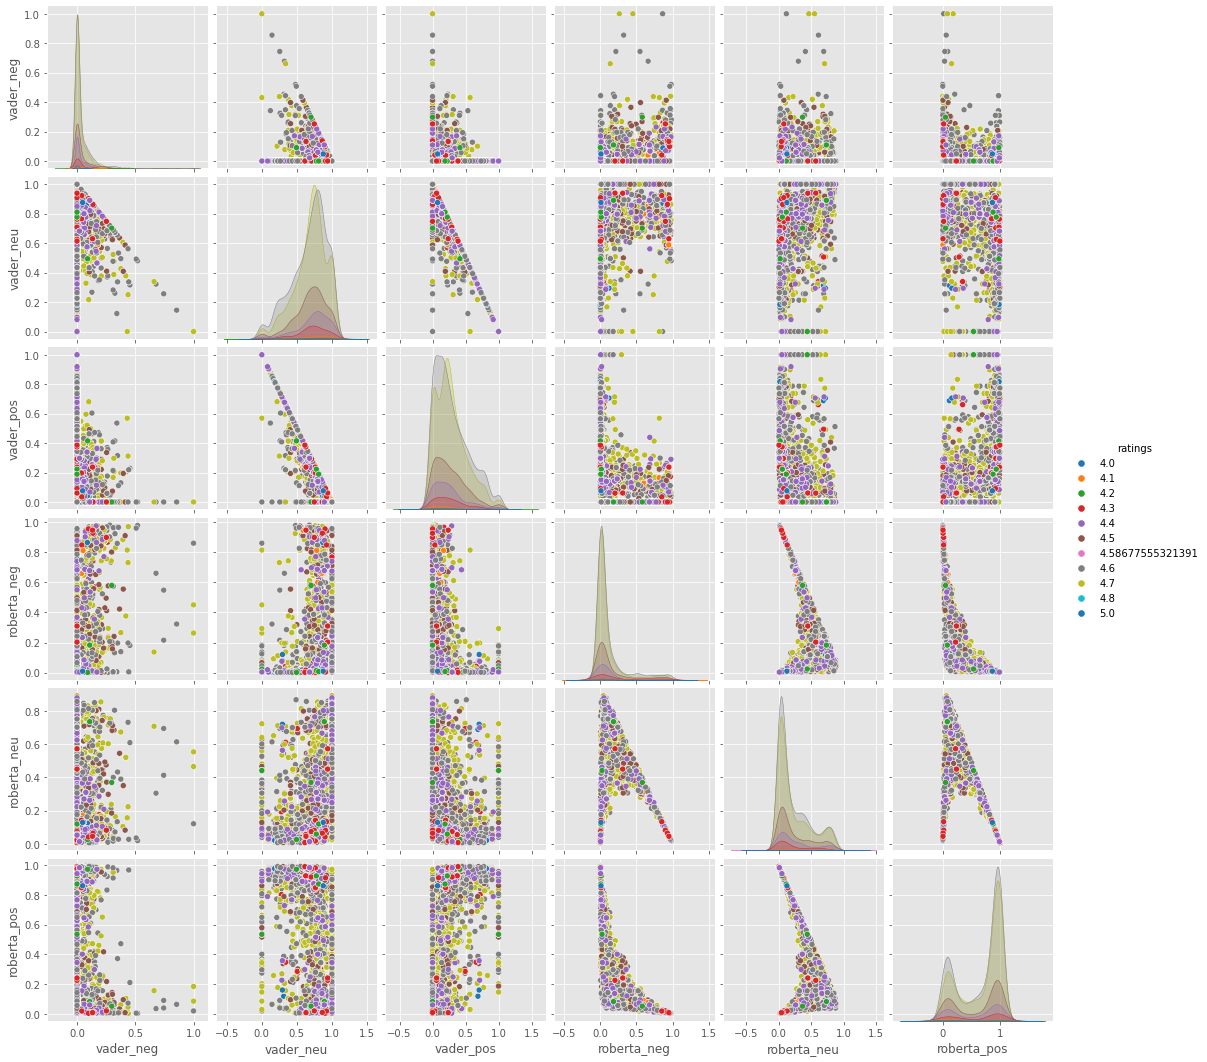

In [47]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='ratings',
            palette='tab10')
plt.show()

## (IV) Review Examples

- Positive 5-Star and Negative 1-Star Reviews

Model scoring and review score differ the most.

In [48]:
results_df.query('ratings == 5') \
    .sort_values('roberta_pos', ascending=False)['contents'].values[0]

'Bucket hat with SPF and a pocket! The pocket was useful for keeping my resort key away from my cell phone! 😂😅 Bought a L for my large and and braids. Still had room to breathe and no headaches at the end of the day.'

In [49]:
results_df.query('ratings == 5') \
    .sort_values('vader_pos', ascending=False)['contents'].values[0]

'Bucket hat with SPF and a pocket! The pocket was useful for keeping my resort key away from my cell phone! 😂😅 Bought a L for my large and and braids. Still had room to breathe and no headaches at the end of the day.'

In [50]:
results_df.query('ratings == 4.2') \
    .sort_values('roberta_pos', ascending=False)['contents'].values[0]

'Great Hat for all your adventures no matter where you are or go. Never Stop Exploring! TNF!'

In [51]:
results_df.query('ratings == 4.2') \
    .sort_values('vader_pos', ascending=False)['contents'].values[0]

'Thanks'

In [52]:
results_df.query('ratings == 4.5') \
    .sort_values('roberta_pos', ascending=False)['contents'].values[0]

'Looks great in the gray on my blonde headed son with the reddish skin!! And he loves it!!❤️'

In [53]:
results_df.query('ratings == 4.5') \
    .sort_values('vader_pos', ascending=False)['contents'].values[0]

'excellent'

In [54]:
results_df.query('ratings == 4.5').sort_values('roberta_pos', ascending=False)

,index,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,name,price,reviewers,dates,ratings,titles,contents,converted_ratings,titles_contents,length
1351,1392,0.000,0.641,0.359,0.8741,0.001269,0.005370,0.993361,THE NORTH FACE Canyonlands Full Zip Mens Fleece,$89.95,julia patton,2023-05-18,4.5,Great jacket,Looks great in the gray on my blonde headed so...,1,Great jacket. Looks great in the gray on my bl...,20
1310,1351,0.000,0.641,0.359,0.8741,0.001269,0.005370,0.993361,THE NORTH FACE Canyonlands Full Zip Mens Fleece,$89.95,Jwh,2023-06-07,4.5,New Balance- XL,Looks great in the gray on my blonde headed so...,1,New Balance- XL. Looks great in the gray on my...,21
1301,1341,0.000,0.641,0.359,0.8741,0.001269,0.005370,0.993361,THE NORTH FACE Canyonlands Full Zip Mens Fleece,$89.95,Melanie,2022-12-27,4.5,New Balance- XL,Looks great in the gray on my blonde headed so...,1,New Balance- XL. Looks great in the gray on my...,21
2702,2828,0.000,0.549,0.451,0.8122,0.001521,0.005976,0.992504,THE NORTH FACE Hedgehog Fastpack II WP Mens Hi...,$58.95,"Otto F. Rohwedder, III",2022-08-18,4.5,New and improved!,Love these shoes. These are even better than m...,1,New and improved!. Love these shoes. These are...,14
1346,1387,0.074,0.421,0.505,0.9059,0.001349,0.006287,0.992364,THE NORTH FACE Canyonlands Full Zip Mens Fleece,$89.95,question,2022-05-12,4.5,Light N What I Expected,"Fit like a typical TnF size M men's, I love th...",1,Light N What I Expected. Fit like a typical Tn...,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,1489,0.077,0.923,0.000,-0.7184,0.946682,0.048403,0.004915,THE NORTH FACE Anchor 1/4 Zip Mens Fleece,$64.95,Paula M. Roycroft,2023-05-16,4.5,BAD Quality Control and Warranty 🤬🤬🤬🤬🤬🤬,"Ordered in September, 2022 for trip to Switzer...",1,BAD Quality Control and Warranty 🤬🤬🤬🤬🤬🤬. Order...,85
2726,2852,0.119,0.881,0.000,-0.4767,0.926022,0.069438,0.004540,THE NORTH FACE Hedgehog Fastpack II WP Mens Hi...,$58.95,Tim in Bennington,2021-01-18,4.5,Shoes wear out quickly under causal conditions.,Disappointed with this purchase as the shoes a...,1,Shoes wear out quickly under causal conditions...,31
2648,2773,0.218,0.734,0.047,-0.8586,0.962320,0.033377,0.004303,THE NORTH FACE Truckee Mens Hiking Shoes,$98.95,John M Turner,2022-05-10,4.5,Sent Used/Dirty Shoes,"My husband opened his shoes up today, as they ...",1,Sent Used/Dirty Shoes. My husband opened his s...,56
1560,1620,0.171,0.721,0.108,-0.3400,0.940930,0.055466,0.003605,THE NORTH FACE Half Dome Tri-Blend Mens Tshirt,$29.98,Kim W.,2022-07-18,4.5,Threading,The threading on the sleeves and the bottom of...,1,Threading. The threading on the sleeves and th...,19


## The Transformers Pipeline

In [55]:
from transformers import pipeline

sent_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [56]:
sent_pipeline('I love sentiment analysis')

[{'label': 'POSITIVE', 'score': 0.999736487865448}]

In [57]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

In [58]:
sent_pipeline('so so')

[{'label': 'POSITIVE', 'score': 0.9700967669487}]